In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")
import matplotlib.pyplot as plt
from src.data.data_module import SegmentationDataModule
import torch
import numpy as np
import segmentation_models_pytorch as smp
from src.training.train_model import SegmentationModel
from src.training.models import DinoSegmentor
import lightning as L
from src.utils import deaugment_image
from src.callbacks import SaveStateDictCallback

In [ ]:
import albumentations as A

train_augs = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Normalize last (before converting to tensor)
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.ToTensorV2(),
    ]
)

tier1_dm = SegmentationDataModule(
    train_indices=["/workspace/data/new_processed//tier_1/train.csv"],
    val_indices=["/workspace/data/new_processed/tier_1/val.csv"],
    train_augs=train_augs,
    val_augs=train_augs,
    batch_size=8,
)

In [15]:
tier1_dm.setup()

In [16]:
for b in tier1_dm.train_dataloader():
    break

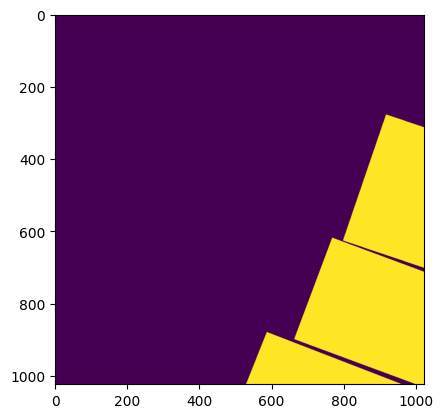

In [17]:
x, y = b
plt.imshow(y[0])

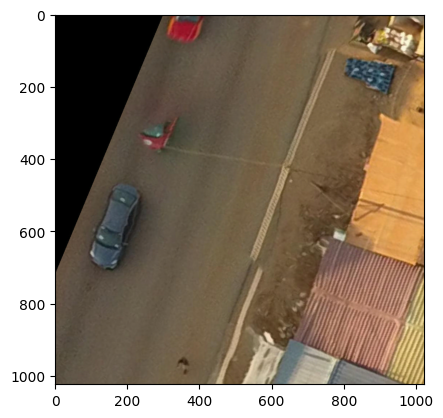

In [18]:
plt.imshow(deaugment_image(x[0]))

In [8]:
x.shape

torch.Size([8, 3, 1024, 1024])

In [9]:
ENCODER = "se_resnext50_32x4d"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ["roof"]
ACTIVATION = None  # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = "cuda"

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=None,
).to(DEVICE)

In [19]:
SegmentationModel?

Init signature:
SegmentationModel(
    model: 'nn.Module',
    lr: 'float' = 0.0001,
    weight_decay: 'float' = 0.0001,
    optimizer_name: "Literal['adam', 'adamw', 'sgd']" = 'adamw',
    loss_fn: 'Optional[Callable[[torch.Tensor, torch.Tensor], torch.Tensor]]' = None,
    threshold: 'float' = 0.5,
    device: 'Any' = None,
)
Docstring:     
Generic LightningModule for binary segmentation using TorchMetrics MetricCollection.

Any model must return logits: (B, 1, H, W)
File:           /workspace/src/training/train_model.py
Type:           type
Subclasses:     

In [21]:
model = SegmentationModel(
    model=model,
    loss_fn=smp.losses.DiceLoss(mode="binary"),
    device=DEVICE,
)

In [22]:
# trainer = L.Trainer()
trainer = L.Trainer(
    precision="16",
    max_epochs=20,
    callbacks=[SaveStateDictCallback(save_dir="fpn_nia", prefix="fpn_epoch")],
)

/opt/conda/envs/main_11/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [23]:
trainer.fit(model, tier1_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/main_11/lib/python3.11/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ SegmentationModel │ 28.1 M │ train │     0 │
│ 1 │ loss_fn       │ DiceLoss          │      0 │ train │     0 │
│ 2 │ train_metrics │ MetricCollection  │      0 │ train │     0 │
│ 3 │ val_metrics   │ MetricCollection  │      0 │ train │     0 │
│ 4 │ test_metrics  │ MetricCollection  │      0 │ train │     0 │
└───┴───────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 28.1 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 28.1 M                                                                                               
Total estimated model params size (MB): 112                                                                        
Modules in train mode: 339                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_000.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_001.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_002.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_003.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_004.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_005.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_006.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_007.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_008.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_009.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_010.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_011.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_012.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_013.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_014.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_015.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_016.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_017.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_018.pth

[SaveSMPStateDictCallback] Saved: fpn_nia/fpn_epoch_019.pth

`Trainer.fit` stopped: `max_epochs=20` reached.


In [13]:
from pathlib import Path
import pandas as pd


def get_metrics(model_folder):
    metrics_log = []
    for model_pt in Path(model_folder).glob("*.pth"):
        model.model.load_state_dict(torch.load(model_pt))
        metrics = trainer.validate(model, tier1_dm)[0]
        metrics["model"] = model_pt.stem
        metrics_log.append(metrics)
    metrics_df = pd.DataFrame(metrics_log)
    metrics_df.to_csv(model_folder / "metrics.csv")
    return metrics_df


metrics_df = get_metrics("fpn_nia")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.1306772530078888     │
│       val_iou_epoch       │    0.07009083777666092    │
│         val_loss          │    0.26169154047966003    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.5099931955337524     │
│       val_iou_epoch       │    0.3454062044620514     │
│         val_loss          │    0.23829936981201172    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.6155465245246887     │
│       val_iou_epoch       │    0.44672760367393494    │
│         val_loss          │    0.16079387068748474    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.4709373414516449     │
│       val_iou_epoch       │    0.3099372982978821     │
│         val_loss          │    0.16498801112174988    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7135286331176758     │
│       val_iou_epoch       │    0.5561589598655701     │
│         val_loss          │    0.09802526235580444    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7209981083869934     │
│       val_iou_epoch       │    0.5653400421142578     │
│         val_loss          │    0.08890674263238907    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │     0.693709671497345     │
│       val_iou_epoch       │    0.5327430367469788     │
│         val_loss          │    0.09291264414787292    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7619501948356628     │
│       val_iou_epoch       │    0.6167066097259521     │
│         val_loss          │    0.07701829075813293    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.8240788578987122     │
│       val_iou_epoch       │     0.70157390832901      │
│         val_loss          │    0.06307096779346466    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.8478607535362244     │
│       val_iou_epoch       │    0.7362545132637024     │
│         val_loss          │   0.058375127613544464    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │     0.85237717628479      │
│       val_iou_epoch       │    0.7431808114051819     │
│         val_loss          │    0.05370503291487694    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.8133826851844788     │
│       val_iou_epoch       │    0.6868189573287964     │
│         val_loss          │   0.058221958577632904    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │     0.850171685218811     │
│       val_iou_epoch       │    0.7402366995811462     │
│         val_loss          │    0.05089414864778519    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.8691876530647278     │
│       val_iou_epoch       │    0.7690209746360779     │
│         val_loss          │   0.048081062734127045    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.8716294765472412     │
│       val_iou_epoch       │    0.7729825973510742     │
│         val_loss          │    0.04611511155962944    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.8733392357826233     │
│       val_iou_epoch       │    0.7757329940795898     │
│         val_loss          │   0.044173844158649445    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.8757786750793457     │
│       val_iou_epoch       │    0.7796560525894165     │
│         val_loss          │   0.042997319251298904    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.8825448751449585     │
│       val_iou_epoch       │    0.7903522849082947     │
│         val_loss          │    0.04111246019601822    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │     0.885432243347168     │
│       val_iou_epoch       │    0.7949399352073669     │
│         val_loss          │    0.03988253325223923    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.8949633836746216     │
│       val_iou_epoch       │    0.8101447820663452     │
│         val_loss          │    0.03813331201672554    │
└───────────────────────────┴───────────────────────────┘

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
metrics_df.to_csv("metrics.csv")